In [1]:
import pandas as pd
import numpy as np
import os
import re
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt

# Prediction based on AGE

## Pre-processing
### Functions for pre-processing

In [2]:
def index_pre_process(dataframe, pattern, pattern_1):
    '''
    Pre-processing involves following steps:
    1. Transpose, such that state codes are columns, and age category is indexes
    2. Add population of all state codes to a single column for each category.
    3. Keep the total population including male and female for each age category
    4. Here we have 0,1,2,3,4 age categories and 0-4 age categories, we will delete indexes of 0,1,2,3,4, since
    0-4 is same and this will be easier with less data but same information
    '''
    
    # Transpose step
    dataframe_copy = dataframe.T.copy()
    
    # New column with total sum
    dataframe_copy['total_sum'] = pd.Series(np.sum(dataframe_copy, axis=1))
    
    # removal of all other columns except for 'total sum column'
    dataframe_copy.drop(labels = (list(dataframe_copy.columns))[:-1], axis = 1, inplace = True)
    
    # removal of indexes with 'M' or 'F' and only '0 to 4' kind of categories
    index_list = list(dataframe_copy.index)
#     updated_index_list = [words for words in index_list
#                           if ('M' not in words) & ('F' not in words) & (len(re.findall(pattern = pattern, string = words)) > 0) & (len(re.findall(pattern = pattern_1, string = words)) == 0)]

    updated_index_list = [words for words in index_list
                          if ('M' not in words) & ('F' not in words) & ((len(re.findall(pattern = pattern, string = words)) > 0) | (len(re.findall(pattern = pattern_1, string = words)) > 0))]


    dataframe_copy = dataframe_copy.loc[updated_index_list, :]
    
    return dataframe_copy
    

In [3]:
def get_dataframe(path, file_location_1, file_location_2, file_location_3, file_location_4, file_location_5):
    # creating dataframes
    age_file_df_1 = pd.read_csv(filepath_or_buffer = os.path.join(path, file_location_1), index_col = 0)
    age_file_df_2 = pd.read_csv(filepath_or_buffer = os.path.join(path, file_location_2), index_col = 0)
    age_file_df_3 = pd.read_csv(filepath_or_buffer = os.path.join(path, file_location_3), index_col = 0)
    age_file_df_4 = pd.read_csv(filepath_or_buffer = os.path.join(path, file_location_4), index_col = 0)
    age_file_df_5 = pd.read_csv(filepath_or_buffer = os.path.join(path, file_location_5), index_col = 0)
    
    # using other definition
    pattern = '_[0-9]+_'
    pattern_1 = '_[0-9]+[a-z]+_'
    age_df_1 = index_pre_process(dataframe = age_file_df_1, pattern = pattern, pattern_1 = pattern_1)
    age_df_2 = index_pre_process(dataframe = age_file_df_2, pattern = pattern, pattern_1 = pattern_1)
    age_df_3 = index_pre_process(dataframe = age_file_df_3, pattern = pattern, pattern_1 = pattern_1)
    age_df_4 = index_pre_process(dataframe = age_file_df_4, pattern = pattern, pattern_1 = pattern_1)
    age_df_5 = index_pre_process(dataframe = age_file_df_5, pattern = pattern, pattern_1 = pattern_1)
    
    # contcat all the dataframes
    age_df_combined = pd.concat([age_df_1, age_df_2,age_df_3,age_df_4,age_df_5], axis = 0)
    
    # remove dates like 0_to_4
    age_df_combined_index = list(age_df_combined.index)
    pattern_2 = '_[0-9]+_[0-9]+_'
    updated_index_list_1 = [word for word in age_df_combined_index
                            if len(re.findall(pattern = pattern_2, string = word)) == 0]
    age_df_combined = age_df_combined.loc[updated_index_list_1,:]
    
    return age_df_combined

In [4]:
direcotry_path = '2016_TSP_STE_for_NSW_short-header/2016 Census TSP States and Territories for NSW/'
file_path_1 = '2016Census_T03A_NSW_STE.csv'
file_path_2 = '2016Census_T03B_NSW_STE.csv'
file_path_3 = '2016Census_T03C_NSW_STE.csv'
file_path_4 = '2016Census_T03D_NSW_STE.csv'
file_path_5 = '2016Census_T03E_NSW_STE.csv'

In [5]:
df = get_dataframe(
                        path = direcotry_path,
                        file_location_1 = file_path_1,
                        file_location_2 = file_path_2,
                        file_location_3 = file_path_3,
                        file_location_4 = file_path_4,
                        file_location_5 = file_path_5
)

In [6]:
df_index = list(df.index)
df['year'] = [words[-4:-2] for words in df_index]

In [7]:
index_list_06 = [data for data in df_index
                 if df.loc[data,'year'] == '06']
index_list_11 = [data for data in df_index
                 if df.loc[data,'year'] == '11']
index_list_16 = [data for data in df_index
                 if df.loc[data,'year'] == '16']

In [8]:
df_06 = df.loc[index_list_06, :]
df_11 = df.loc[index_list_11, :]
df_16 = df.loc[index_list_16, :]

In [9]:
df_06_index = df_06.index

* Age 18 under population
* 18-24,
* 25-34,  
* 35-44,  
* 45-54,  
* 55-64,  
* 65 and older

In [10]:
# under 18
zero_18_06 = np.sum(df_06.iloc[:19, 0])
zero_18_11 = np.sum(df_11.iloc[:19, 0])
zero_18_16 = np.sum(df_16.iloc[:19, 0])

# 18 to 25
zero_19_24_06 = np.sum(df_06.iloc[19:25, 0])
zero_19_24_11 = np.sum(df_11.iloc[19:25, 0])
zero_19_24_16 = np.sum(df_16.iloc[19:25, 0])

# 25 to 34
zero_25_34_06 = np.sum(df_06.iloc[25:35, 0])
zero_25_34_11 = np.sum(df_11.iloc[25:35, 0])
zero_25_34_16 = np.sum(df_16.iloc[25:35, 0])

# 35 to 44
zero_35_44_06 = np.sum(df_06.iloc[35:45, 0])
zero_35_44_11 = np.sum(df_11.iloc[35:45, 0])
zero_35_44_16 = np.sum(df_16.iloc[35:45, 0])

# 45 to 54
zero_45_54_06 = np.sum(df_06.iloc[45:55, 0])
zero_45_54_11 = np.sum(df_11.iloc[45:55, 0])
zero_45_54_16 = np.sum(df_16.iloc[45:55, 0])

# 55 to 64
zero_55_64_06 = np.sum(df_06.iloc[55:65, 0])
zero_55_64_11 = np.sum(df_11.iloc[55:65, 0])
zero_55_64_16 = np.sum(df_16.iloc[55:65, 0])

# 65 above
zero_65_ab_06 = np.sum(df_06.iloc[65:, 0])
zero_65_ab_11 = np.sum(df_11.iloc[65:, 0])
zero_65_ab_16 = np.sum(df_16.iloc[65:, 0])


In [11]:
age_df = pd.DataFrame()
age_df['2006_data'] = pd.Series([zero_18_06, zero_19_24_06, zero_25_34_06, zero_35_44_06, zero_45_54_06, zero_55_64_06, zero_65_ab_06])
age_df['2011_data'] = pd.Series([zero_18_11, zero_19_24_11, zero_25_34_11, zero_35_44_11, zero_45_54_11, zero_55_64_11, zero_65_ab_11])
age_df['2016_data'] = pd.Series([zero_18_16, zero_19_24_16, zero_25_34_16, zero_35_44_16, zero_45_54_16, zero_55_64_16, zero_65_ab_16])

age_df.index = ['below 18 years', '18 to 25', '25 to 34', '35 to 44', '45 to 54', '55 to 64', '65 above']

In [12]:
age_df_transposed = age_df.T
age_df_transposed.index = ['2006', '2011', '2016']
# age_df_transposed.index = pd.DatetimeIndex(data = age_df_transposed.index)
age_df_transposed['Dates'] = age_df_transposed.index
age_df_transposed.index = ['1', '2','3']
age_df_transposed

,below 18 years,18 to 25,25 to 34,35 to 44,45 to 54,55 to 64,65 above,Dates
1,1653876,516768,891047,957844,904337,719539,765073,2006
2,1688546,537074,941508,971638,950456,810292,867459,2011
3,1742488,581935,1067528,1002882,977983,889760,1061819,2016


In [13]:
age_df_transposed['total_population'] = np.sum(age_df_transposed.iloc[:,:-1], axis = 1)
cols = list(age_df_transposed.columns)
a, b = cols.index('total_population'), cols.index('Dates')
cols[b], cols[a] = cols[a], cols[b]
age_df_transposed = age_df_transposed[cols]
age_df_transposed

,below 18 years,18 to 25,25 to 34,35 to 44,45 to 54,55 to 64,65 above,total_population,Dates
1,1653876,516768,891047,957844,904337,719539,765073,6408484,2006
2,1688546,537074,941508,971638,950456,810292,867459,6766973,2011
3,1742488,581935,1067528,1002882,977983,889760,1061819,7324395,2016


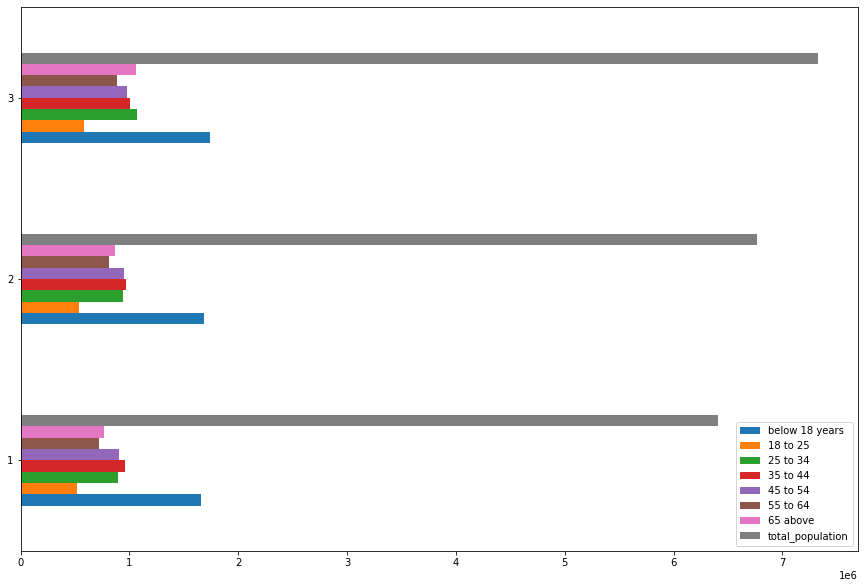

In [14]:
age_df_transposed.plot(kind = 'barh', figsize = (15,10))

## Regression models

In [15]:
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, SGDRegressor, PoissonRegressor

In [16]:
def model_results(model, age_df_transposed, column):
    X = (age_df_transposed.index).values
    y = age_df_transposed.iloc[:,column].values
    X = X.reshape(-1,1)
    y = y.reshape(-1,1)
    column_names = age_df_transposed.columns
#     linear_model = LinearRegression()
    model.fit(X, y)
    X_test = ['4','5','6']
    X_test = np.array(X_test, dtype = 'object')
    X_test = X_test.reshape(-1,1)
    prediction = model.predict(X_test)
    plt.bar(['2006', '2011', '2016','2021', '2026', '2031'], np.append(age_df_transposed.iloc[:,column].values,prediction))
    plt.title(column_names[column])
    plt.show()
    return prediction

In [17]:
def create_dataframe(model, dataframe, cols):
    prediction_results_partial = []
    prediction_results_nested = []
    prediction_dates = ['2021', '2026', '2031']
    for i in range(len(cols[:-1])):
        prediction_results_partial.append(model_results(model,
                                                        age_df_transposed = dataframe,
                                                        column = i))
        prediction_results_nested.append(prediction_results_partial)
        prediction_results_partial = []
    new_df = pd.DataFrame()
    for i in range(len(prediction_results_nested)):
        new_df[i] = pd.Series(np.hstack(prediction_results_nested[i][0]))
    new_df.index = prediction_dates
    column_names = dataframe.columns
    new_df.columns = cols[:-1]
    return new_df

In [18]:
def reset_df(age_df):
    age_df_transposed = age_df.T
    age_df_transposed.index = ['2006', '2011', '2016']
    # age_df_transposed.index = pd.DatetimeIndex(data = age_df_transposed.index)
    age_df_transposed['Dates'] = age_df_transposed.index
    age_df_transposed.index = ['1', '2','3']
    age_df_transposed['total_population'] = np.sum(age_df_transposed.iloc[:,:-1], axis = 1)
    cols = list(age_df_transposed.columns)
    a, b = cols.index('total_population'), cols.index('Dates')
    cols[b], cols[a] = cols[a], cols[b]
    age_df_transposed = age_df_transposed[cols]
    return age_df_transposed, cols

age_df_transposed, cols = reset_df(age_df = age_df)

### Linear Regression

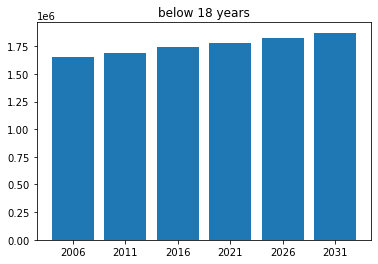

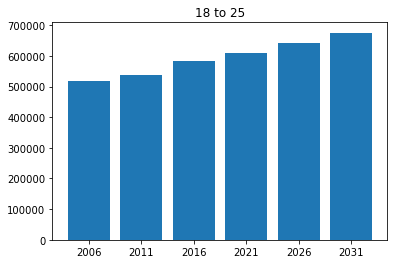

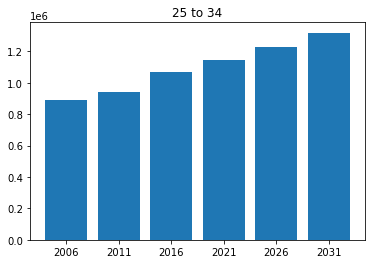

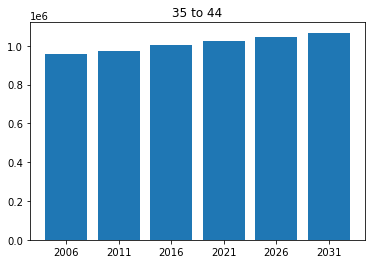

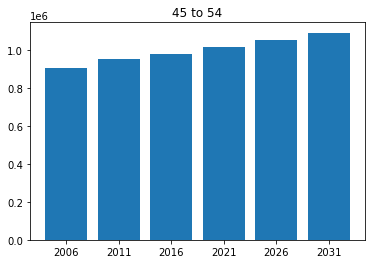

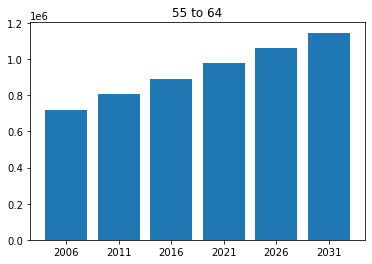

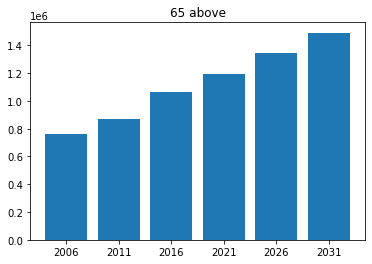

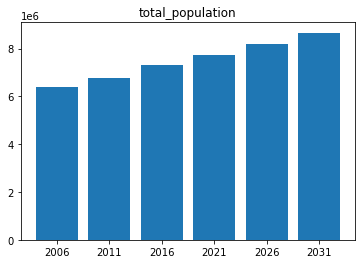

In [19]:
model = LinearRegression()
linear_prediction_df = create_dataframe(model, age_df_transposed, cols)
age_df_transposed.index = age_df_transposed.Dates
df_with_linear_results = pd.concat([age_df_transposed.drop(labels = 'Dates', axis = 1), linear_prediction_df])

In [20]:
df_with_linear_results = df_with_linear_results.add_suffix('_linear_model')
df_with_linear_results

,below 18 years_linear_model,18 to 25_linear_model,25 to 34_linear_model,35 to 44_linear_model,45 to 54_linear_model,55 to 64_linear_model,65 above_linear_model,total_population_linear_model
2006,1653876.0,516768.0,8.910470e+05,9.578440e+05,9.043370e+05,7.195390e+05,765073.0,6408484.0
2011,1688546.0,537074.0,9.415080e+05,9.716380e+05,9.504560e+05,8.102920e+05,867459.0,6766973.0
2016,1742488.0,581935.0,1.067528e+06,1.002882e+06,9.779830e+05,8.897600e+05,1061819.0,7324395.0
2021,1783582.0,610426.0,1.143175e+06,1.022493e+06,1.017905e+06,9.767513e+05,1194863.0,7749195.0
2026,1827888.0,643009.5,1.231416e+06,1.045012e+06,1.054728e+06,1.061862e+06,1343236.0,8207150.5
2031,1872194.0,675593.0,1.319656e+06,1.067531e+06,1.091551e+06,1.146972e+06,1491609.0,8665106.0


### Huber Regression Model

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


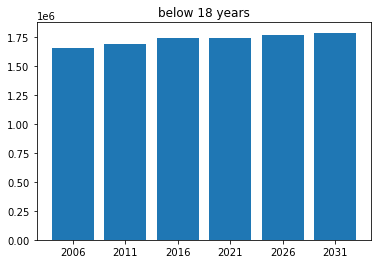

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


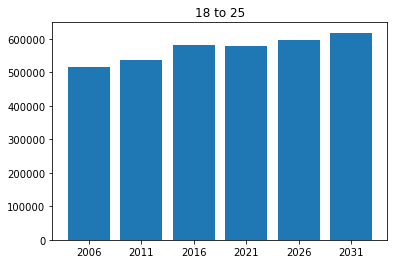

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


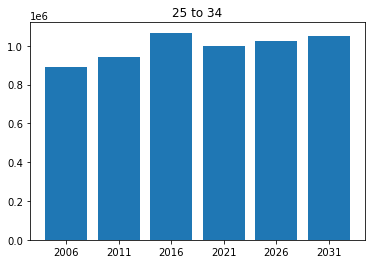

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


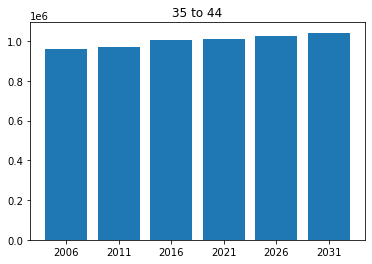

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


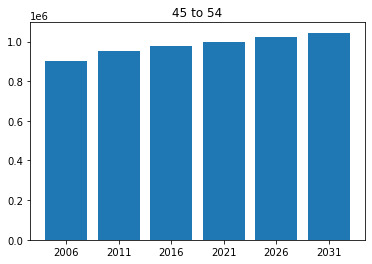

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


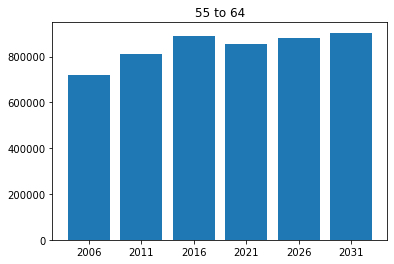

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


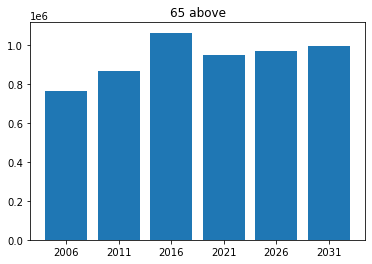

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


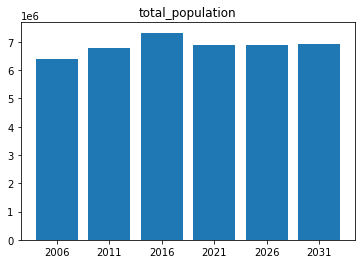

In [21]:
age_df_transposed, cols = reset_df(age_df = age_df)
huber_model = HuberRegressor()
huber_prediction_df = create_dataframe(huber_model, age_df_transposed, cols)
age_df_transposed.index = age_df_transposed.Dates
df_with_huber_results = pd.concat([age_df_transposed.drop(labels = 'Dates', axis = 1), huber_prediction_df])


In [22]:
df_with_huber_results = df_with_huber_results.add_suffix('_huber_model')
df_with_huber_results

,below 18 years_huber_model,18 to 25_huber_model,25 to 34_huber_model,35 to 44_huber_model,45 to 54_huber_model,55 to 64_huber_model,65 above_huber_model,total_population_huber_model
2006,1.653876e+06,516768.000000,8.910470e+05,9.578440e+05,9.043370e+05,719539.000000,7.650730e+05,6.408484e+06
2011,1.688546e+06,537074.000000,9.415080e+05,9.716380e+05,9.504560e+05,810292.000000,8.674590e+05,6.766973e+06
2016,1.742488e+06,581935.000000,1.067528e+06,1.002882e+06,9.779830e+05,889760.000000,1.061819e+06,7.324395e+06
2021,1.740921e+06,577738.905809,1.000594e+06,1.008841e+06,9.967112e+05,855449.615679,9.460281e+05,6.881850e+06
2026,1.764820e+06,598059.030736,1.024493e+06,1.025443e+06,1.020610e+06,879909.256289,9.699836e+05,6.906133e+06
2031,1.788718e+06,618379.155664,1.048392e+06,1.042044e+06,1.044508e+06,904368.896900,9.939392e+05,6.930416e+06


### RANSAC Regression

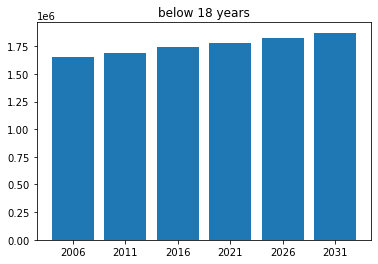

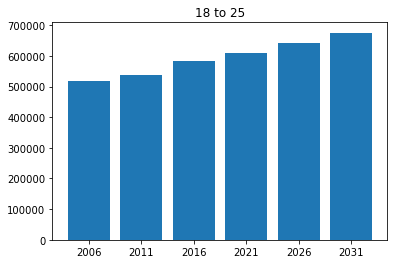

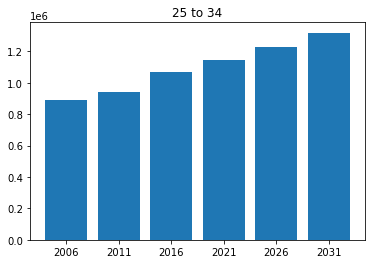

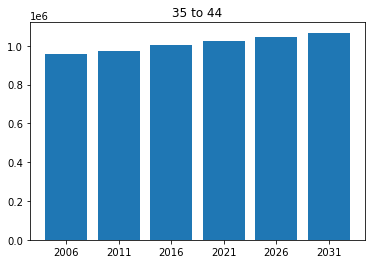

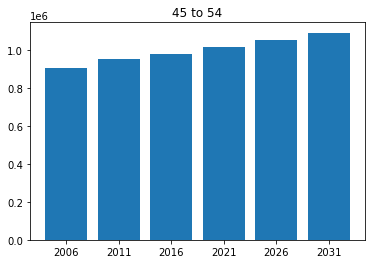

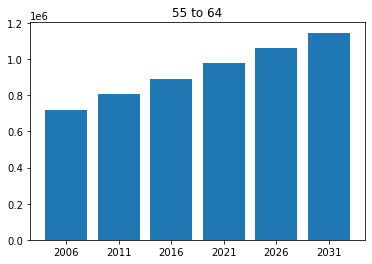

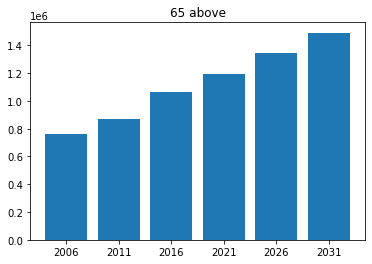

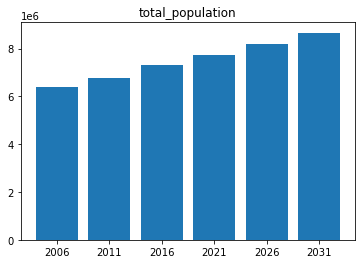

In [23]:
age_df_transposed, cols = reset_df(age_df = age_df)
ransac_model = RANSACRegressor()
ransac_prediction_df = create_dataframe(ransac_model, age_df_transposed, cols)
age_df_transposed.index = age_df_transposed.Dates
df_with_ransac_results = pd.concat([age_df_transposed.drop(labels = 'Dates', axis = 1), ransac_prediction_df])


In [24]:
df_with_ransac_results = df_with_ransac_results.add_suffix('_ransac_model')
df_with_ransac_results

,below 18 years_ransac_model,18 to 25_ransac_model,25 to 34_ransac_model,35 to 44_ransac_model,45 to 54_ransac_model,55 to 64_ransac_model,65 above_ransac_model,total_population_ransac_model
2006,1653876.0,516768.0,8.910470e+05,9.578440e+05,9.043370e+05,7.195390e+05,765073.0,6408484.0
2011,1688546.0,537074.0,9.415080e+05,9.716380e+05,9.504560e+05,8.102920e+05,867459.0,6766973.0
2016,1742488.0,581935.0,1.067528e+06,1.002882e+06,9.779830e+05,8.897600e+05,1061819.0,7324395.0
2021,1783582.0,610426.0,1.143175e+06,1.022493e+06,1.017905e+06,9.767513e+05,1194863.0,7749195.0
2026,1827888.0,643009.5,1.231416e+06,1.045012e+06,1.054728e+06,1.061862e+06,1343236.0,8207150.5
2031,1872194.0,675593.0,1.319656e+06,1.067531e+06,1.091551e+06,1.146972e+06,1491609.0,8665106.0


### SGD Regression

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


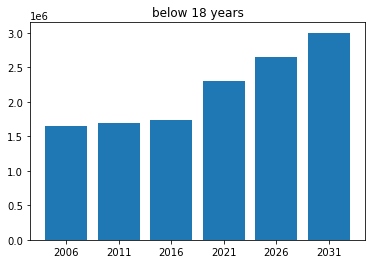

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


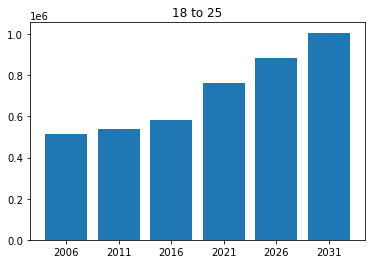

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


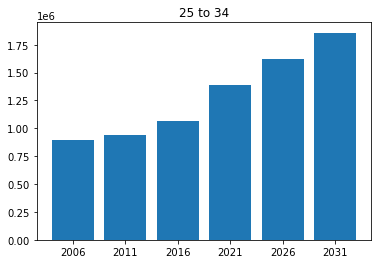

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


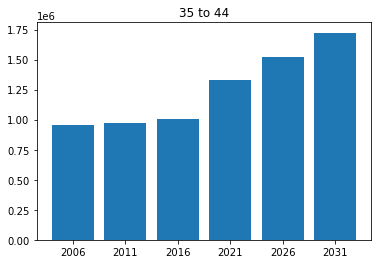

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


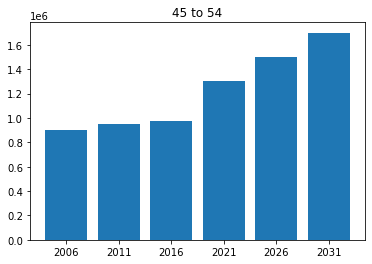

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


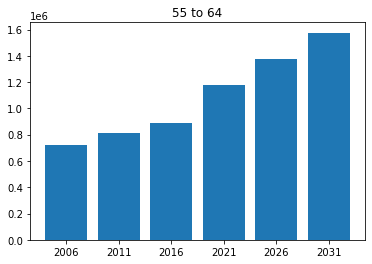

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


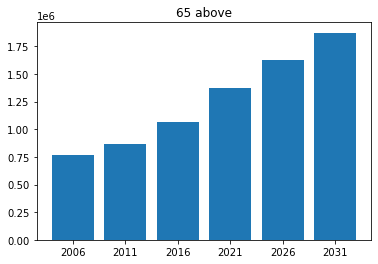

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


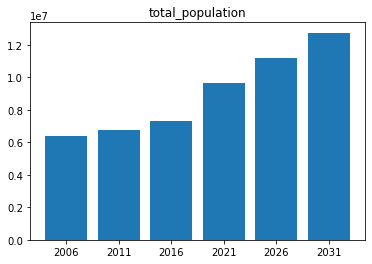

In [25]:
age_df_transposed, cols = reset_df(age_df = age_df)
sgd_model = SGDRegressor()
sgd_prediction_df = create_dataframe(sgd_model, age_df_transposed, cols)
age_df_transposed.index = age_df_transposed.Dates
df_with_sgd_results = pd.concat([age_df_transposed.drop(labels = 'Dates', axis = 1), sgd_prediction_df])

In [26]:
df_with_sgd_results = df_with_sgd_results.add_suffix('_SGD_model')
df_with_sgd_results

,below 18 years_SGD_model,18 to 25_SGD_model,25 to 34_SGD_model,35 to 44_SGD_model,45 to 54_SGD_model,55 to 64_SGD_model,65 above_SGD_model,total_population_SGD_model
2006,1.653876e+06,5.167680e+05,8.910470e+05,9.578440e+05,9.043370e+05,7.195390e+05,7.650730e+05,6.408484e+06
2011,1.688546e+06,5.370740e+05,9.415080e+05,9.716380e+05,9.504560e+05,8.102920e+05,8.674590e+05,6.766973e+06
2016,1.742488e+06,5.819350e+05,1.067528e+06,1.002882e+06,9.779830e+05,8.897600e+05,1.061819e+06,7.324395e+06
2021,2.305388e+06,7.638991e+05,1.392410e+06,1.325860e+06,1.298770e+06,1.175270e+06,1.371051e+06,9.632348e+06
2026,2.652996e+06,8.856382e+05,1.625130e+06,1.524709e+06,1.498862e+06,1.375482e+06,1.621796e+06,1.118433e+07
2031,3.000605e+06,1.007377e+06,1.857850e+06,1.723559e+06,1.698954e+06,1.575694e+06,1.872540e+06,1.273631e+07


### Poission Regression

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


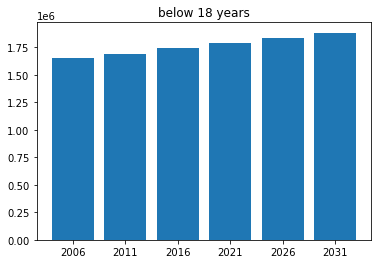

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


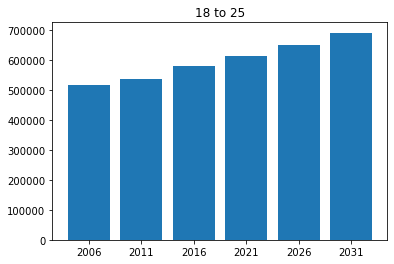

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


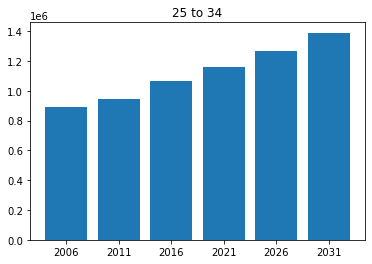

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


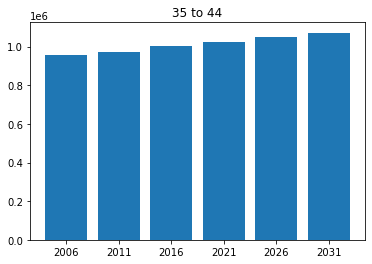

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


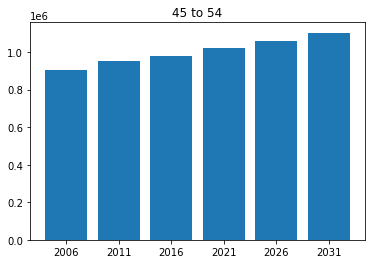

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


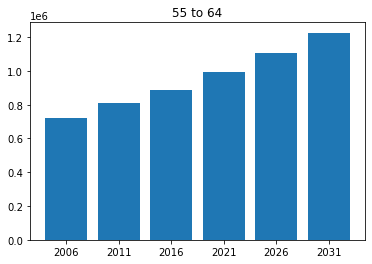

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


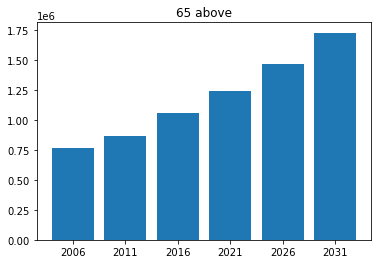

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


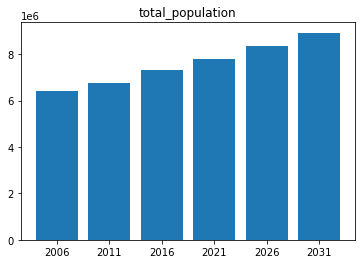

In [27]:
age_df_transposed, cols = reset_df(age_df = age_df)
poisson_model = PoissonRegressor()
poisson_prediction_df = create_dataframe(poisson_model, age_df_transposed, cols)
age_df_transposed.index = age_df_transposed.Dates
df_with_poisson_results = pd.concat([age_df_transposed.drop(labels = 'Dates', axis = 1), poisson_prediction_df])


In [28]:
df_with_poisson_results = df_with_poisson_results.add_suffix('_poission_prediction')
df_with_poisson_results

,below 18 years_poission_prediction,18 to 25_poission_prediction,25 to 34_poission_prediction,35 to 44_poission_prediction,45 to 54_poission_prediction,55 to 64_poission_prediction,65 above_poission_prediction,total_population_poission_prediction
2006,1.653876e+06,516768.000000,8.910470e+05,9.578440e+05,9.043370e+05,7.195390e+05,7.650730e+05,6.408484e+06
2011,1.688546e+06,537074.000000,9.415080e+05,9.716380e+05,9.504560e+05,8.102920e+05,8.674590e+05,6.766973e+06
2016,1.742488e+06,581935.000000,1.067528e+06,1.002882e+06,9.779830e+05,8.897600e+05,1.061819e+06,7.324395e+06
2021,1.785543e+06,613791.979180,1.157380e+06,1.023369e+06,1.020355e+06,9.927364e+05,1.240244e+06,7.802496e+06
2026,1.832837e+06,651612.038327,1.268159e+06,1.047222e+06,1.060942e+06,1.103440e+06,1.464143e+06,8.343746e+06
2031,1.881384e+06,691762.458446,1.389542e+06,1.071631e+06,1.103144e+06,1.226489e+06,1.728461e+06,8.922542e+06


In [29]:
def plot_comparison_results(column_number, df_with_linear_results, df_with_huber_results, df_with_sgd_results, df_with_ransac_results, df_with_poisson_results):
    a = pd.concat([df_with_linear_results.iloc[:,column_number],
                   df_with_huber_results.iloc[:, column_number],
                   df_with_sgd_results.iloc[:,column_number],
                   df_with_ransac_results.iloc[:,column_number],
                   df_with_poisson_results.iloc[:,column_number]],
                  axis = 1)
    a.iloc[3:,:].plot(kind = 'bar', figsize = (7,7))

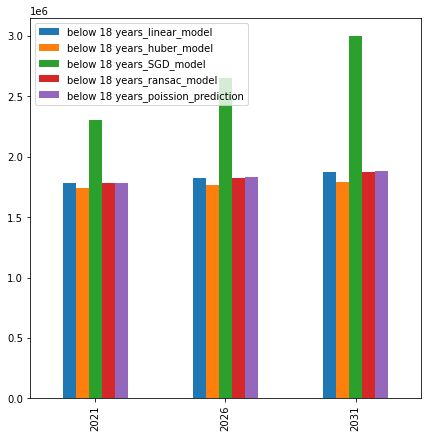

In [30]:
plot_comparison_results(0,df_with_linear_results, df_with_huber_results, df_with_sgd_results, df_with_ransac_results, df_with_poisson_results)

# Prediction based on AGE

### Pre-processing steps

In [31]:
# since total population of male and female is required for year 06, 11, 16, we will only take the last file
age_file_df_5 = pd.read_csv(filepath_or_buffer = os.path.join(direcotry_path, file_path_5))
column_names = list(age_file_df_5.columns)
required_column_names = [names for names in column_names
                         if ('Tot' in names) & ('P' not in names)]
age_file_df_5_transpose = age_file_df_5[required_column_names].T

# extract the year from the index values
df_index = list(age_file_df_5_transpose.index)
age_file_df_5_transpose['year'] = [words[-4:-2] for words in df_index]

# selection of columns with either male or female, combination of both are not selected
male_series = [male for male in age_file_df_5_transpose.index
               if 'M' in male]
female_series = [male for male in age_file_df_5_transpose.index
                 if 'F' in male]
male_series_df = age_file_df_5_transpose.loc[male_series,:]
female_series_df = age_file_df_5_transpose.loc[female_series,:]

# after selecting male or female, changing the column name to male population and female population
male_series_df = male_series_df.rename(columns = {0: 'Male_Population',
                                                  'year': 'Year'})
female_series_df = female_series_df.rename(columns ={0: 'Female_Population'})

# changing the index for regression models
male_series_df.index = [1,2,3]
female_series_df.index = [1,2,3]

# combining the male and female dataframes to get a single dataframe
combined_gender_df = pd.concat([male_series_df, female_series_df], axis = 1)
combined_gender_df.drop(labels = 'Year', axis = 1, inplace = True)
combined_gender_df

,Male_Population,Female_Population,year
1,3228451,3320726,06
2,3408880,3508782,11
3,3686014,3794217,16


In [32]:
def reset_index_gender_df(dataframe):
    dataframe.index = ['1', '2', '3']
    cols = list(dataframe.columns)
    return dataframe, cols

### Regression Models

#### Linear Regression

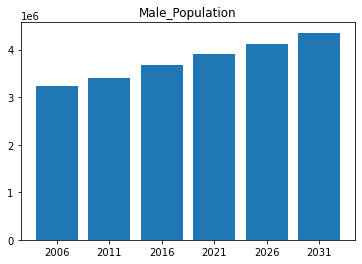

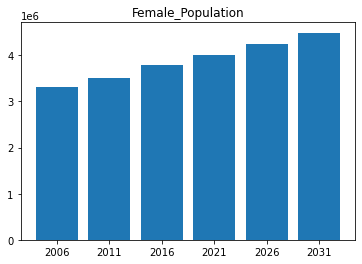

In [33]:
combined_gender_df, cols = reset_index_gender_df(combined_gender_df)
model = LinearRegression()
linear_prediction_df = create_dataframe(model, combined_gender_df, cols)
combined_gender_df.index = ['2006', '2011', '2016']
df_with_linear_results_gender = pd.concat([combined_gender_df, linear_prediction_df])
df_with_linear_results_gender.drop(labels = 'year', axis = 1, inplace = True)

In [34]:
df_with_linear_results_gender = df_with_linear_results_gender.add_suffix('_linear_model')
df_with_linear_results_gender

,Male_Population_linear_model,Female_Population_linear_model
2006,3228451.0,3.320726e+06
2011,3408880.0,3.508782e+06
2016,3686014.0,3.794217e+06
2021,3898678.0,4.014733e+06
2026,4127459.5,4.251478e+06
2031,4356241.0,4.488224e+06


#### Huber Regression Model

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


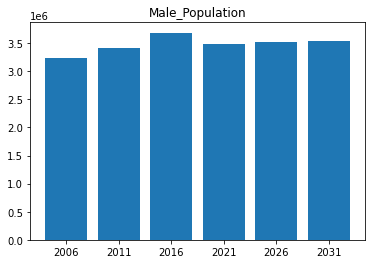

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


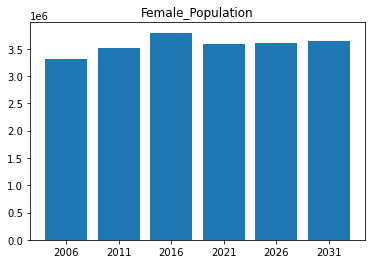

In [35]:
combined_gender_df, cols = reset_index_gender_df(combined_gender_df)
model = HuberRegressor()
huber_prediction_df = create_dataframe(model, combined_gender_df, cols)
combined_gender_df.index = ['2006', '2011', '2016']
df_with_huber_results_gender = pd.concat([combined_gender_df, huber_prediction_df])
df_with_huber_results_gender.drop(labels = 'year', axis = 1, inplace = True)

In [36]:
df_with_huber_results_gender = df_with_huber_results_gender.add_suffix('_huber_model')
df_with_huber_results_gender

,Male_Population_huber_model,Female_Population_huber_model
2006,3.228451e+06,3.320726e+06
2011,3.408880e+06,3.508782e+06
2016,3.686014e+06,3.794217e+06
2021,3.489655e+06,3.589808e+06
2026,3.513924e+06,3.614091e+06
2031,3.538194e+06,3.638375e+06


#### RANSAC Regression Model

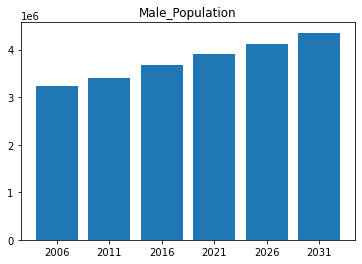

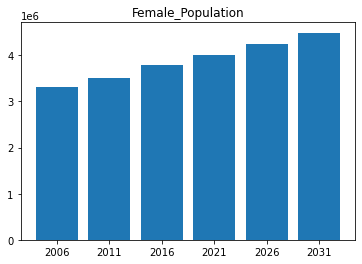

In [37]:
combined_gender_df, cols = reset_index_gender_df(combined_gender_df)
model = RANSACRegressor()
ransac_prediction_df = create_dataframe(model, combined_gender_df, cols)
combined_gender_df.index = ['2006', '2011', '2016']
df_with_ransac_results_gender = pd.concat([combined_gender_df, ransac_prediction_df])
df_with_ransac_results_gender.drop(labels = 'year', axis = 1, inplace = True)

In [38]:
df_with_ransac_results_gender = df_with_ransac_results_gender.add_suffix('_ransac_model')
df_with_ransac_results_gender

,Male_Population_ransac_model,Female_Population_ransac_model
2006,3228451.0,3.320726e+06
2011,3408880.0,3.508782e+06
2016,3686014.0,3.794217e+06
2021,3898678.0,4.014733e+06
2026,4127459.5,4.251478e+06
2031,4356241.0,4.488224e+06


#### SGD Regression Model

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


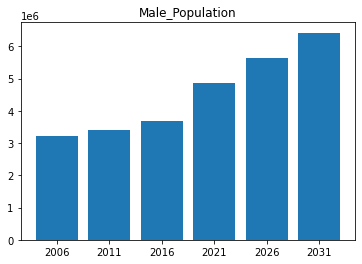

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


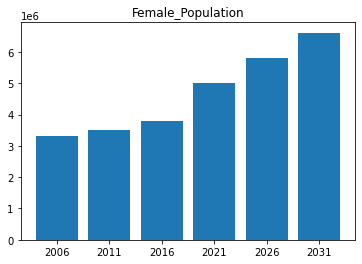

In [39]:
combined_gender_df, cols = reset_index_gender_df(combined_gender_df)
model = SGDRegressor()
sgd_prediction_df = create_dataframe(model, combined_gender_df, cols)
combined_gender_df.index = ['2006', '2011', '2016']
df_with_sgd_results_gender = pd.concat([combined_gender_df, sgd_prediction_df])
df_with_sgd_results_gender.drop(labels = 'year', axis = 1, inplace = True)

In [40]:
df_with_sgd_results_gender = df_with_sgd_results_gender.add_suffix('_sgd_model')
df_with_sgd_results_gender

,Male_Population_sgd_model,Female_Population_sgd_model
2006,3.228451e+06,3.320726e+06
2011,3.408880e+06,3.508782e+06
2016,3.686014e+06,3.794217e+06
2021,4.855136e+06,4.998184e+06
2026,5.638416e+06,5.805056e+06
2031,6.421695e+06,6.611928e+06


#### Poission Regression Model

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


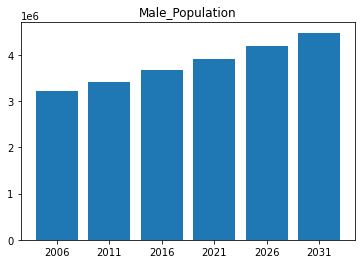

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


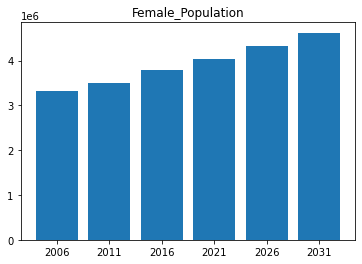

In [41]:
combined_gender_df, cols = reset_index_gender_df(combined_gender_df)
model = PoissonRegressor()
poisson_prediction_df = create_dataframe(model, combined_gender_df, cols)
combined_gender_df.index = ['2006', '2011', '2016']
df_with_poisson_results_gender = pd.concat([combined_gender_df, poisson_prediction_df])
df_with_poisson_results_gender.drop(labels = 'year', axis = 1, inplace = True)

In [42]:
df_with_poisson_results_gender = df_with_poisson_results_gender.add_suffix('_poisson_model')
df_with_poisson_results_gender

,Male_Population_poisson_model,Female_Population_poisson_model
2006,3.228451e+06,3.320726e+06
2011,3.408880e+06,3.508782e+06
2016,3.686014e+06,3.794217e+06
2021,3.925085e+06,4.042217e+06
2026,4.195119e+06,4.321908e+06
2031,4.483730e+06,4.620951e+06


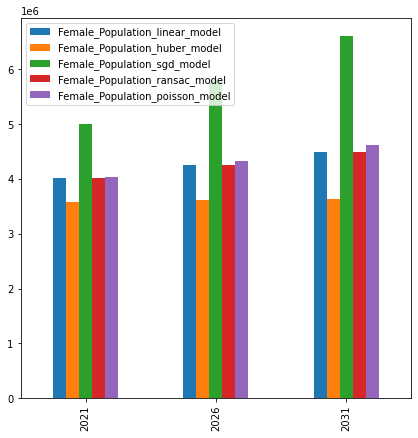

In [43]:
plot_comparison_results(1,
                        df_with_linear_results_gender, 
                        df_with_huber_results_gender, 
                        df_with_sgd_results_gender, 
                        df_with_ransac_results_gender, 
                        df_with_poisson_results_gender)